# Model Inputs

"ml_input.csv" can be retrieved from 03-Sample-Prep (single dataframe w/ train and test sets)

### Packages

In [2]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Classfication
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Visualization
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [3]:
# Loading output dataframe from data.ipynb
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

# Filter non-specific ec numbers (e.g., 1.1.1,-)
filter = df["ec"].str.contains("-")
df = df[~filter]

# Format for machine learning
df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]
df_test = df[bins]
df

ec,taxon_id,media_id,1.1.1.1,1.1.1.100,1.1.1.101,1.1.1.102,1.1.1.103,1.1.1.105,1.1.1.107,1.1.1.108,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,100.0,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,J386,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100225.0,J233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002526.0,J22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004166.0,1a,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8706,KBase_derived_Bin.033.fastaLS_S_extracted_bins...,unknown,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8707,KBase_derived_Bin.034.fastaCA_F_extracted_bins...,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8708,KBase_derived_Bin.037.fastaLS_S_extracted_bins...,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8709,KBase_derived_Bin.038.fastaLS_S_extracted_bins...,unknown,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split dataset

In [4]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 #47 = seed for random_state reported in thesis

# Test case with MAGs
X_train = df_train.drop(["taxon_id", "media_id"], axis=1)
y_train = df_train[TARGET] 
X_test = df_test.drop(["taxon_id", "media_id"], axis=1)
y_test = df_test[TARGET]

# Model

### Pipeline

In [5]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(
        n_components=150,      
        random_state= RANDOM_SEED
        )),    
    ('umap', umap.UMAP(      
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=40, 
        n_neighbors=62, 
        min_dist=0 
        )) 
])

### Fit and transform

In [6]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Cluster

In [7]:
# Cluster
clusterer = KMeans(n_clusters=182, random_state=RANDOM_SEED)
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [8]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

# UMAP and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)

print(f"Total PCA explained variance: {explained_variance.sum()}")
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}")

# 0.8768 182 0.7809

Total PCA explained variance: 0.8764737414669707
182 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.7741259336471558


# Classifier

In [9]:
y2_train = cluster_labels
y2_test = test_clusters

### Random Forest

In [10]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[138 163 138 138 163 117  94  94 117 117  94 138  94  94 163   3 138 155
 123  94 181   3 117  94  94  94 163 117  94  94   3 156  67 156 138  94
  94 138 138 163  94 117 138 163  94 163  94  94 138  94 138   3 138 138
 117 138 141  94 117 138  94 138 117 117  94   3  94  94 117 138  94 138
  94 117  94 138 138  94  94  94  94  94  94  94   3  94  94 138   3 153
 138   3  94  94 138  94 155 131 163 181   3 123 156 117 117  94  94  94
  94 117 117 138 117 138 181  94 138 117 117 163 117   3 163 138 138 138
 138  94 123 181 163 163 138 138   3   3 163  94 117 138 131  94  94 156
 138  47 163 138   3 117  94 117  94 138 163 138   3 138 117  94 138 138
 138 117 141   3 181   3 163 163   3 163 123 117 138  94  47 138  94 181
 138 163 163  94  94  94  94 117 138  94  94 163   3 138   3 163 181   3
 138 123  94 163 123 117   3 155 181 138 117  94 131  94   3  94 163  94
 163 123 163   3 163  94   3   3   3   3 163   3  94 155 181   3  94   3
 117 138   3 117   3 123 138 163 181  94  94  94 12

In [11]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        32
          47       1.00      1.00      1.00         2
          67       1.00      1.00      1.00         1
          94       0.88      0.98      0.93        62
         117       0.74      0.72      0.73        32
         123       1.00      1.00      1.00         9
         131       1.00      1.00      1.00         3
         138       0.94      1.00      0.97        47
         141       0.00      0.00      0.00         0
         153       1.00      0.33      0.50         3
         155       0.75      0.60      0.67         5
         156       1.00      1.00      1.00         4
         163       1.00      0.76      0.87        38
         181       0.90      1.00      0.95         9

    accuracy                           0.91       247
   macro avg       0.87      0.81      0.83       247
weighted avg       0.92      0.91      0.91       247

RF ROC AUC score: 0.99433

### Nearest Neighbors

In [12]:
knc= KNeighborsClassifier(n_neighbors=1)
knc.fit(X_train_transformed, cluster_labels)
distances, indices = knc.kneighbors(X_test_transformed)

print(knc.predict(X_test_transformed))

[138 163 138 138 163 117 181 117 163 117  94 138  94  94 163   3 138 117
 123  94 181   3 163  94  94  94 163 117  94  94   3 156  67 156 138  94
  94 138 138 163  94 163 138 163  94 163  94  94 138  94 138   3 138 138
 117 138 141  94 117 138  94 138 117 117  94   3  94  94 117 138  94 138
  94 117  94 138 138  94  94 117  94  94  94  94   3  94  94 138   3 153
 138   3 117 117 138  94 117 131 163 181   3 123 156 117 163 181  94  94
  94 163 163 138  94 138 181  94 138 117 117 163 117   3 163 138 138 138
 138  94 123 181 163 163 138 138   3   3 163  94 117 138 131  94  94 156
 138  47 163 138   3 163  94 163  94 138 163 138   3 138 117  94 138 138
 138 117 156   3 181   3 163 163   3 163 123 163 138  94  47 138  94 181
 138 163 163 117 117  94  94 117 138  94  94 163   3 138   3 117  94   3
 138 123  94 163 123 117   3 155 181 138 117  94 131 117   3 117 163  94
 163 123 163   3 163  94   3   3   3   3 163   3 117 117 181   3  94   3
 117 138   3 117   3 123 138 163 117  94 117  94 12

In [13]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        32
          47       1.00      1.00      1.00         2
          67       1.00      1.00      1.00         1
          94       0.95      0.90      0.93        62
         117       0.72      0.81      0.76        32
         123       1.00      1.00      1.00         9
         131       1.00      1.00      1.00         3
         138       0.94      1.00      0.97        47
         141       0.00      0.00      0.00         0
         153       1.00      0.33      0.50         3
         155       1.00      0.20      0.33         5
         156       0.80      1.00      0.89         4
         163       0.89      0.87      0.88        38
         181       0.80      0.89      0.84         9

    accuracy                           0.90       247
   macro avg       0.86      0.79      0.79       247
weighted avg       0.91      0.90      0.90       247

KNN ROC AUC score: 0.9300

# Outputs

### Train, clustering labels

In [14]:
# Training data
train_df = pd.DataFrame(X_train_transformed, columns=[f"Component {i+1}" for i in range(X_train_transformed.shape[1])])
train_df['Set'] = 'Training'
train_df['Target'] = y_train
train_df['KMeans Cluster'] = cluster_labels
train_df['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
target_label_mapping = dict(zip(media_clusters['media_id'], media_clusters['Media Cluster']))
train_df['Media Cluster'] = train_df['Target'].map(target_label_mapping)

train_df.to_csv(os.path.join(DATA_DIR, "model", "train-output.csv"), index=False)
train_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 36,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,Media Cluster
0,8.877258,5.368573,5.976608,5.567410,5.752917,4.890731,5.484498,5.908564,4.930583,5.352659,...,6.869729,4.994915,5.778642,3.910152,3.630782,Training,J346,112,100.0,6.0
1,9.131594,5.638107,5.949810,5.132954,4.882958,4.661012,5.534887,6.839547,4.804379,2.488934,...,4.965437,4.965490,5.094551,5.412997,5.210567,Training,J386,164,100.0,3.0
2,8.647167,5.515614,4.541187,4.840522,4.230924,4.675780,4.592118,3.662642,6.307117,8.584105,...,9.143206,4.835721,7.085607,3.096110,5.055593,Training,J233,3,100225.0,NaN
3,8.713597,5.501556,5.008151,5.610324,5.525953,4.904368,5.518972,4.571458,5.482652,7.380622,...,8.304418,5.090847,6.794505,2.982144,3.715566,Training,J22,119,1002526.0,9.0
4,9.308442,5.575479,4.788660,4.720118,4.320899,4.483849,4.655216,4.801590,6.320374,6.760714,...,4.880169,4.442428,7.164841,4.876586,5.876074,Training,1a,58,1004166.0,9.0


### Test, classifier labels

In [15]:
# Test data
test_df = pd.DataFrame(X_test_transformed, columns=[f"Component {i+1}" for i in range(X_test_transformed.shape[1])])
test_df['Set'] = 'Test'
test_df['Target'] = list(df_test['media_id'])
test_df['KMeans Cluster'] = test_clusters
test_df['taxon_id'] = list(df_test['taxon_id'])

# Add classifier labels 
test_df["KNN Classify"] = knc.predict(X_test_transformed)
test_df["RF Classify"] = rfc.predict(X_test_transformed)

test_df.to_csv(os.path.join(DATA_DIR, "model", "test-output.csv"), index=False)
test_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,taxon_id,KNN Classify,RF Classify
0,9.427101,5.556786,5.026694,4.718250,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,4.342175,6.616252,4.765223,5.496040,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138
1,9.438310,5.577195,4.848787,4.642054,4.625227,4.483598,4.409244,4.932186,5.987401,6.837227,...,4.543643,6.369204,4.772368,5.501478,Test,unknown,163,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163
2,9.447886,5.541127,5.050786,4.717380,4.655841,4.581066,4.613263,4.935236,5.921442,6.821482,...,4.308320,6.693200,4.771678,5.495061,Test,unknown,138,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138
3,9.474887,5.521941,5.061490,4.708226,4.687949,4.567853,4.590333,4.946699,5.907719,6.889503,...,4.317766,6.713403,4.738154,5.454133,Test,unknown,138,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138
4,9.431704,5.578809,4.869885,4.653165,4.616782,4.497761,4.442394,4.926748,5.984292,6.815331,...,4.511312,6.415678,4.784357,5.515740,Test,unknown,163,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163


### ID nearest neighbors

In [16]:
# Add nearest neighbor indices to the test dataframe
knn_df = test_df.copy()
knn_df = knn_df.rename(columns={"KMeans Cluster": "Test Cluster"})
neighbors = pd.DataFrame(indices) # Indices of nearest neighbors from the training set
knn_df['indices'] = neighbors[neighbors.columns[0:]].apply(lambda x: ';'.join(x.dropna().astype(str)), axis=1)
knn_df["indices"] = knn_df["indices"].str.split(';')
knn_df = knn_df.explode("indices")

# Add original indices as a column for the train dataframe
train_index = train_df.copy()
train_index = train_index.rename(columns={"KMeans Cluster": "Train Cluster"})
train_index["indices"] = df_train.index
train_index["indices"] = train_index["indices"].astype(str)

# Merge to label nearest neighbors
left = knn_df.copy()
right = train_index[["indices", "Target", "taxon_id", "Media Cluster"]]
right = right.rename(columns={"Target": "neighbor_media_id", "taxon_id": "neighbor_taxon_id", "Cluster": "neighbor_cluster"})
merged = pd.merge(left, right, on="indices", how="left")

merged.to_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"), index=False)
merged.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Set,Target,Test Cluster,taxon_id,KNN Classify,RF Classify,indices,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,9.427101,5.556786,5.026694,4.718250,4.642046,4.580091,4.598486,4.929774,5.921600,6.780723,...,Test,unknown,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,6167,J654,438.0,10.0
1,9.438310,5.577195,4.848787,4.642054,4.625227,4.483598,4.409244,4.932186,5.987401,6.837227,...,Test,unknown,163,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163,4436,1076b,28127.0,19.0
2,9.447886,5.541127,5.050786,4.717380,4.655841,4.581066,4.613263,4.935236,5.921442,6.821482,...,Test,unknown,138,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138,1426,J256,1496.0,NaN
3,9.474887,5.521941,5.061490,4.708226,4.687949,4.567853,4.590333,4.946699,5.907719,6.889503,...,Test,unknown,138,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138,4818,600a,2966552.0,6.0
4,9.431704,5.578809,4.869885,4.653165,4.616782,4.497761,4.442394,4.926748,5.984292,6.815331,...,Test,unknown,163,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163,4436,1076b,28127.0,19.0


### Feature importance

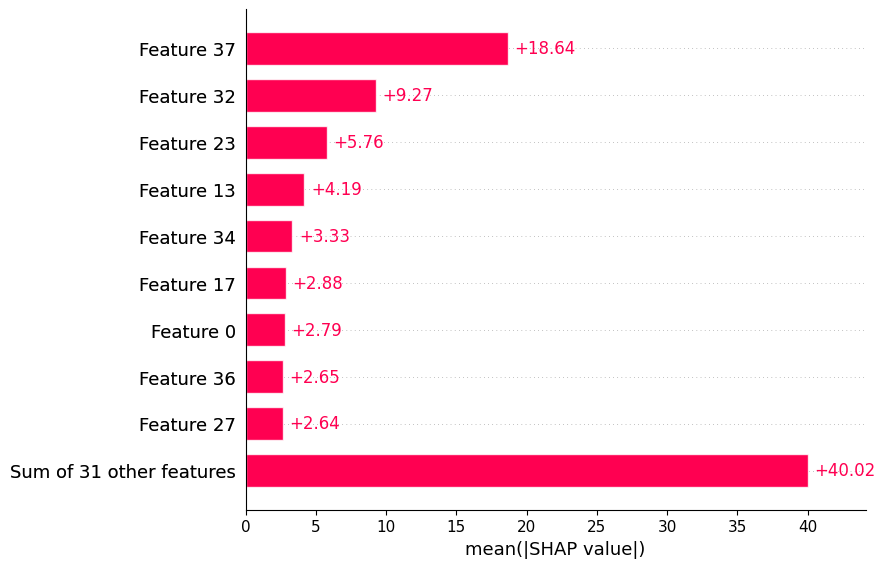

In [17]:
import xgboost
import shap

XG_train = X_train_transformed
yG_train = cluster_labels
XG_test = X_test_transformed
yG_test = test_clusters

model = xgboost.XGBRegressor().fit(XG_train, yG_train)

explainer = shap.Explainer(model)
shap_values = explainer(XG_train) #XG_test

shap.plots.initjs()

#shap.plots.beeswarm(shap_values) #, max_display=40
#shap.plots.waterfall(shap_values[0])
#shap.plots.force(shap_values[:500])
#shap.plots.bar(shap_values.abs.max(0))

shap.plots.bar(shap_values)

# Visualization

### n dimensions

In [22]:
# Highest-importance features (set var to easily change vis)
dim1 = "Component 38" # 31 38
dim2 = "Component 33" # 13 33

# Plot the training points
fig = px.scatter(
    data_frame = train_df,
    x = dim1,
    y = dim2, 
    color = "Media Cluster",
    hover_data = ["taxon_id", "Target", "KMeans Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_df[dim1],  # x coordinates
        y=test_df[dim2],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_df["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

# Make pretty
fig.update_coloraxes(showscale=False)
fig.update_layout(
    sliders=sliders,
    title="Fenix21 (Global Structure)", # Local => limit axis ranges
    template="plotly_white",
    showlegend=False,
    width=500, 
    height=500 #auotfit?
)

fig.update_yaxes(range=[2.25, 4.25])
fig.update_xaxes(range=[2, 8])

fig.show()

In [19]:
# For thesis:

fig = px.scatter(
    data_frame = train_df,
    x = dim1,
    y = dim2, 
    color = "KMeans Cluster",
    hover_data = ["taxon_id", "Target", "Media Cluster"],
    opacity = 0 #0.3 #Toggle training points
) 

fig.add_trace(
    go.Scatter(
        x=test_df[dim1], 
        y=test_df[dim2], 
        mode='markers',
        marker=dict(color='black', size=5, opacity=1.0)
    )
)

fig.update_coloraxes(showscale=False)
fig.update_layout(
    template="plotly_white",
    showlegend=False,
    width=500, 
    height=500
)

# Toggle for global/local structure
fig.update_yaxes(range=[2.25, 4.25])
fig.update_xaxes(range=[2, 8])

fig.show()

# Prediction

In [20]:
predictor = merged.copy()
predictor = predictor.drop(predictor.iloc[:,0:42], axis=1)
predictor = predictor.drop('indices', axis=1)

#predictor.to_csv("~/Desktop/media_mapping/prediction_test_v3/TEST20.csv", index=False) # save under different names for further analysis with each seed
predictor.head()

,Test Cluster,taxon_id,KNN Classify,RF Classify,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,138,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,J654,438.0,10.0
1,163,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163,1076b,28127.0,19.0
2,138,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138,J256,1496.0,NaN
3,138,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138,600a,2966552.0,6.0
4,163,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163,1076b,28127.0,19.0


In [21]:
df = predictor[["taxon_id", "Test Cluster", "KNN Classify", "RF Classify", "neighbor_taxon_id", "neighbor_media_id", "Media Cluster"]]
df = df.rename(columns={
    "Test Cluster": "KM",
    "KNN Classify": "KN", 
    "RF Classify": "RF",
    "neighbor_media_id": "KN Neighbor Media",
    "neighbor_taxon_id": "KN Neighbor ID"
})
df.head()

,taxon_id,KM,KN,RF,KN Neighbor ID,KN Neighbor Media,Media Cluster
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,10.0
1,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163,163,28127.0,1076b,19.0
2,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138,138,1496.0,J256,NaN
3,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138,138,2966552.0,600a,6.0
4,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163,163,28127.0,1076b,19.0
